In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from skimage import color
from skimage import io
from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
from keras import regularizers
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import time


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
path = "Images"
annot = "Airplanes_Annotations"

In [5]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [6]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [7]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [8]:
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [9]:
X = pickle.load(open("X_new.pkl","rb"))
y = pickle.load(open("y_new.pkl","rb"))

In [10]:
y.shape

(45739,)

In [11]:
count=0;
count_1=0;
for i in range(45738):
    if y[i] == 1:
        count=count+1
    else :
        count_1 = count_1+1

In [12]:
count,count_1

(22890, 22848)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((36591, 128, 128, 3), (36591,), (9148, 128, 128, 3), (9148,))

In [15]:
count=0;
count_1=0;
for i in range(36591):
    if y_train[i] == 1:
        count=count+1
    else :
        count_1 = count_1+1


In [16]:
count,count_1

(18455, 18136)

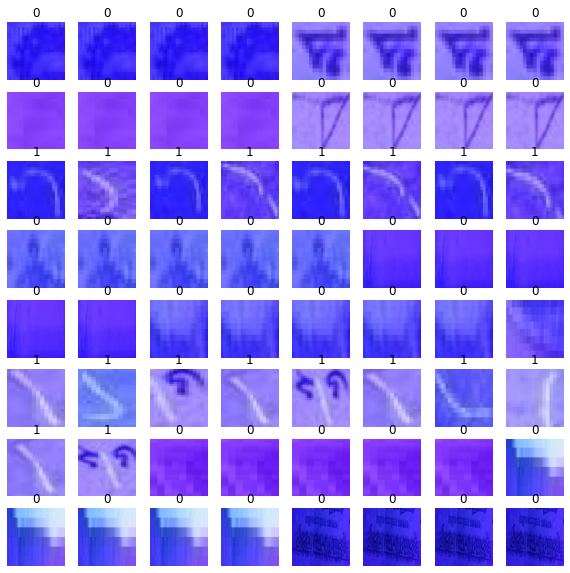

In [17]:
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(cv2.cvtColor(X_train[i],cv2.COLOR_BGR2RGB))
    plt.title(y_train[i])
    #plt.savefig("region", dpi=300)
    plt.axis("off")

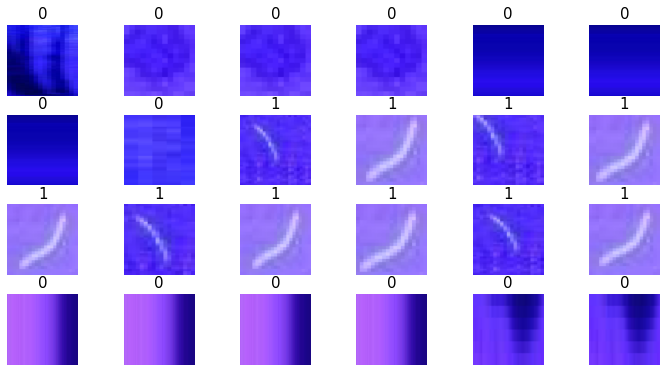

In [45]:
plt.figure(figsize=(10, 5))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(cv2.cvtColor(X_test[i],cv2.COLOR_BGR2RGB))
    plt.title(y_test[i],fontsize=15)
    plt.axis("off")
plt.tight_layout(pad=0.1)    
plt.savefig("region.png", dpi=100)

In [19]:
from tensorflow.keras.callbacks import TensorBoard
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import visualkeras
from keras import regularizers

In [20]:
dense_layers = [1]
layer_sizes = [64]
conv_layers = [5]
img_height=128
img_width=128

In [30]:
%%timeit
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            #print(NAME)

859 ns ± 2.44 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [22]:
import visualkeras

In [31]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            #NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X_train.shape[1:],padding='same'))
            #model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:],padding='same'))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3),padding='same'))
                model.add(Activation('relu'))
            
            model.add(Conv2D(layer_size, (3, 3),padding='same'))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3),padding='same'))
                model.add(Activation('relu'))
            
            model.add(Conv2D(layer_size, (3, 3),padding='same'))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3),padding='same'))
                model.add(Activation('relu'))

            model.add(Conv2D(layer_size, (3, 3),padding='same'))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            
            model.add(Dropout(0.2))
            model.add(Flatten())
            
            #model.add(Dense(layer_size,kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
            model.add(Dense(layer_size))
            model.add(Activation('relu'))
            model.add(Dense(layer_size))
            model.add(Activation('relu'))

            #for _ in range(dense_layer):
             #   model.add(Dense(layer_size))
              #  model.add(Activation('relu'))
            
            model.add(Dropout(0.2))
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            
            model.add(visualkeras.SpacingDummyLayer(spacing=100))

            #tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            #filepath = '/home/anjir29/Desktop/agro/save'
            #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(NAME), histogram_freq=1)
            my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=5),
                            #tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(NAME)),
                            #tf.keras.callbacks.ModelCheckpoint(filepath=filepath,save_freq="epoch")
                            ]

            model.compile(#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          loss='binary_crossentropy',
                          optimizer='Adam',
                          metrics=['accuracy'],
                          )
            
            model.fit(X_train,y_train,
                      batch_size=32,
                      epochs=10,
                      validation_data=(X_test,y_test),
                      callbacks=[my_callbacks])

Epoch 1/10
 177/1144 [===>..........................] - ETA: 1:05 - loss: 0.6864 - accuracy: 0.5517

KeyboardInterrupt: 

In [ ]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
test_acc

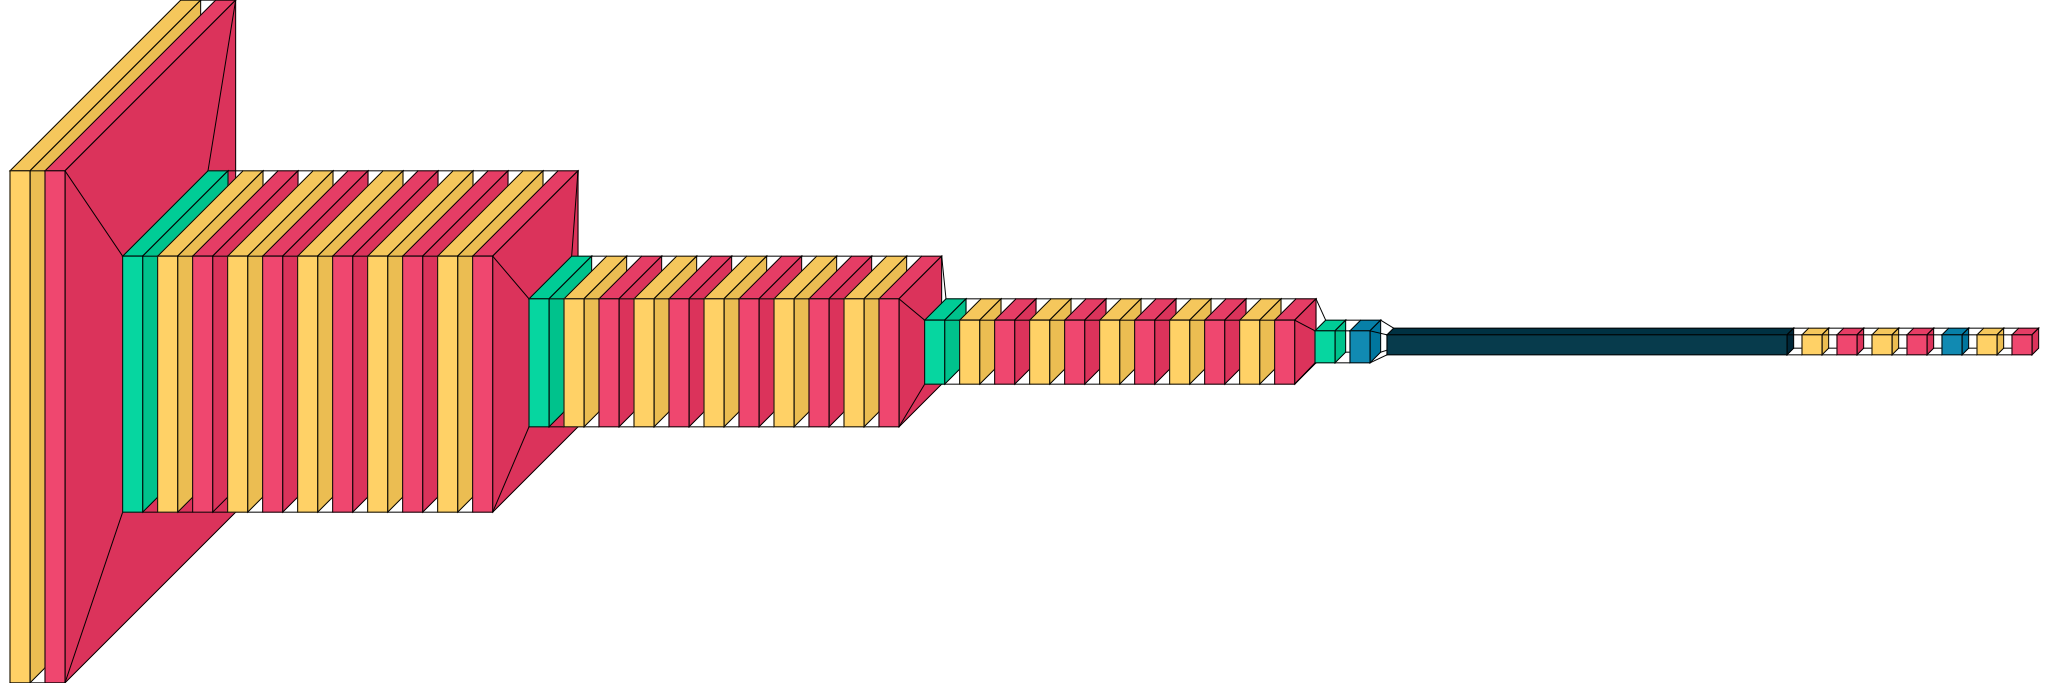

In [26]:
visualkeras.layered_view(model,spacing=15, to_file='output.png')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0

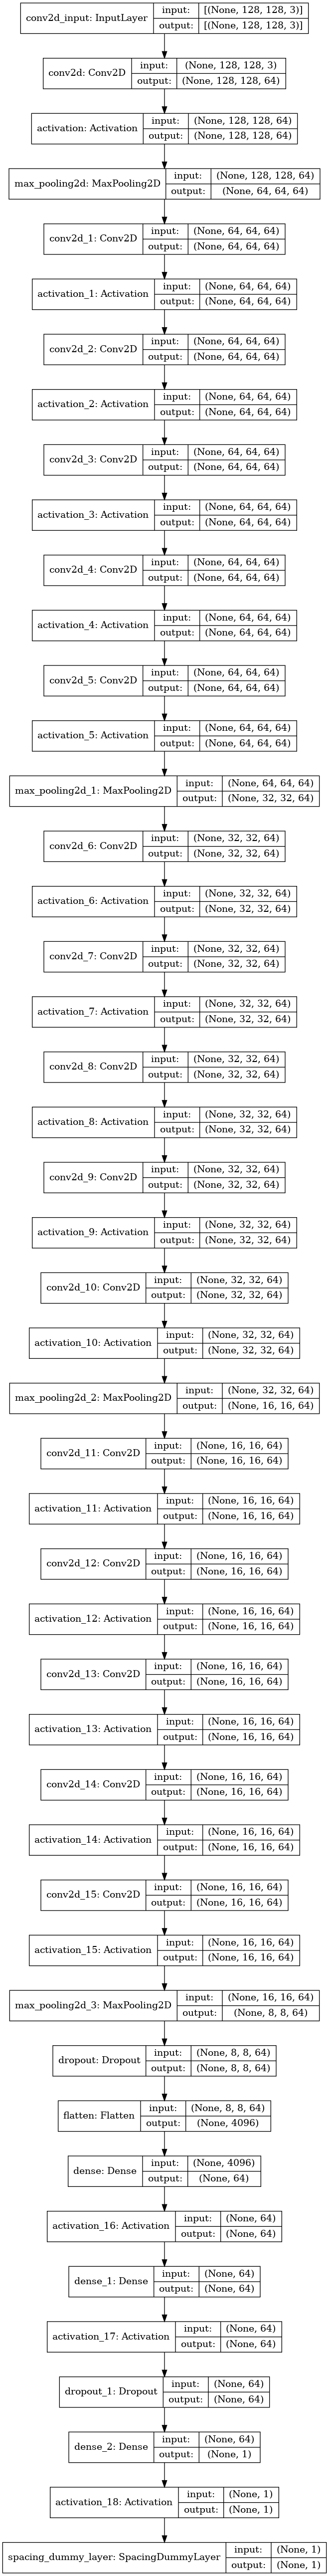

In [28]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
X_test = pickle.load(open("X_test.pkl","rb"))

In [30]:
X_test.shape[0]

21

In [31]:
out= model.predict(X_test)

In [32]:
out

array([[1.5381338e-05],
       [1.5381338e-05],
       [1.5381338e-05],
       [1.5381338e-05],
       [1.9924283e-01],
       [1.9924283e-01],
       [1.9924283e-01],
       [1.9924283e-01],
       [2.0631510e-03],
       [2.0631510e-03],
       [2.0631510e-03],
       [2.0631510e-03],
       [1.3845785e-01],
       [1.3845785e-01],
       [1.3845785e-01],
       [1.3845785e-01],
       [9.9996531e-01],
       [9.9999559e-01],
       [9.9999976e-01],
       [9.9999917e-01],
       [9.9983215e-01]], dtype=float32)

In [33]:
for i in range (20):
    if out[i]>0.9:
        out[i]=1
        print(out)
    else:
        out[i]=0
        

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.9999956 ]
 [0.99999976]
 [0.99999917]
 [0.99983215]]
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [1.        ]
 [0.99999976]
 [0.99999917]
 [0.99983215]]
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999917]
 [0.99983215]]
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0

In [34]:
out

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99983215]], dtype=float32)

/home/anjir29/anaconda3/envs/tf-gpu-2.4/lib/python3.6/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


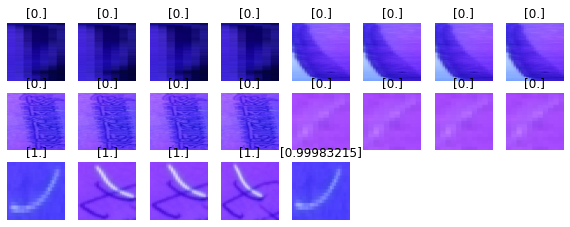

In [35]:
plt.figure(figsize=(10, 10))
for i in range(21):
    plt.subplot(8, 8, i + 1)
    plt.imshow(cv2.cvtColor(X_test[i],cv2.COLOR_BGR2RGB))
    plt.title(out[i])
    #plt.savefig("region", dpi=300)
    plt.axis("off")

In [24]:
font = cv2.FONT_HERSHEY_SIMPLEX 
org = (50, 50) 
fontScale = 1
color = (0, 255, 255)  
font_scale = 1
thickness = 1

In [25]:
def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

Stage_1
Stage_2
--- 1.9073486328125e-06 seconds ---
all done


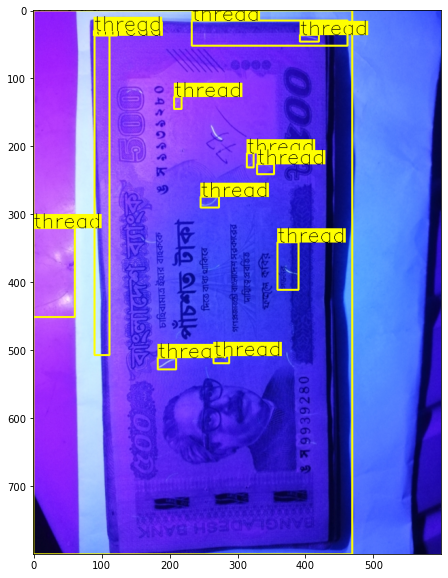

In [34]:
z=0
j=0
boxes=[]
scores=[]
threshold = 0.98
for e,i in enumerate(os.listdir(path)):
    i='001.jpg'
    if i.startswith(""):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        #img = cv2.imread('/home/anjir29/Desktop/Fake_Money/Images/001.jpg')
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        print("Stage_1")
        for e,result in enumerate(ssresults):
            if e < 1000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (128,128), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                #start_time = time.time()
                #print("--- %s seconds ---" % (time.time() - start_time))
                out= model.predict(img)
                #print(out,x,y,x+w,y+h)
                if out > threshold:
                    #print(x,y,x+w,x+h)
                    boxes.append([x,y,x+w,y+h])
                    scores.append(out[0][0])
                    #print(boxes)
        print("Stage_2")
        picked_boxes, picked_score = nms(boxes,scores,0.1)
        #print(picked_boxes)
        for (start_x, start_y, end_x, end_y), confidence in zip(picked_boxes, picked_score):
            if (j!=0 and j!=7) :
                (w, h), baseline = cv2.getTextSize(str(confidence), font, font_scale, thickness)
                cv2.rectangle(imout, (start_x, start_y - (2 * baseline)), (start_x+100, start_y), (0, 255, 255), -1)
                cv2.rectangle(imout, (start_x, start_y), (end_x, end_y), (0, 255, 255), 2)
                cv2.putText(imout, 'thread', (start_x, start_y), font, font_scale, (0, 0, 0), thickness)
                #cv2.rectangle(imout, (x, y), (x+w, y+h), color, thickness, cv2.LINE_AA)
                #cv2.putText (imout,'t'+str(j),(x,y), font,fontScale, color, thickness, cv2.LINE_AA)
                j=j+1
            else :
                j=j+1
        plt.figure(figsize=(10, 10),frameon=False)
        plt.imshow(cv2.cvtColor(imout,cv2.COLOR_BGR2RGB))
        start_time = time.time()
        print("--- %s seconds ---" % (time.time() - start_time))
        #plt.savefig('result1.jpg',dpi=100)
        break
print("all done")

In [ ]:
z=0
threshold = 0.95
for e,i in enumerate(os.listdir(path)):
    i='001.jpg'
    if i.startswith(""):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        #img = cv2.imread('/home/anjir29/Desktop/Fake_Money/Images/001.jpg')
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 100:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (128,128), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model.predict(img)
                #print(out[0][0])
                if out[0][0] > threshold:
                    print(out[0][0])
                    cv2.rectangle(imout, (x, y), (x+w, y+h), color, thickness, cv2.LINE_AA)
                    cv2.putText (imout,'t',(x,y), font,fontScale, color, thickness, cv2.LINE_AA)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(imout,cv2.COLOR_BGR2RGB))
        #plt.savefig('result.png')
        break